In [1]:
! pip install torch
! pip install transformer

ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer


In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 8
N_SPLITS = 5

In [5]:
def get_data(path):
  return pd.read_csv(path)
train_df = get_data('/kaggle/input/clean-data/train.csv')
test_df = get_data('/kaggle/input/clean-data/test.csv')
# su dung kfold
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.label)):
    train_df.loc[val_, "kfold"] = fold

In [6]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [7]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
      if text == 'NEG':
        return 0
      elif text == 'NEU':
        return 1
      else:
        return 2

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        # text = row['Sentence']
        # text = ' '.join(simple_preprocess(text))
        # label = self.labelencoder(row['Emotion'])
        text = row['comment']
        label = self.labelencoder(row['label'])


        return text, label

Text(0.5, 9.444444444444438, 'Token Count')

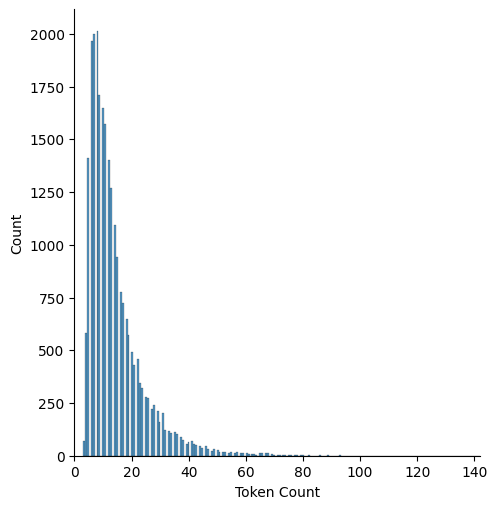

In [8]:
# Distribution of length of Sentence
all_data = train_df['comment'].tolist() + test_df['comment'].tolist()
# all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

In [9]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [10]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [11]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=64)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=64)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [12]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1/8
------------------------------
Train Accuracy: 0.7396691692608192 Loss: 0.6319538434036076
Valid Accuracy: 0.78759765625 Loss: 0.5318092650268227
Epoch 2/8
------------------------------
Train Accuracy: 0.7930781908075444 Loss: 0.5070159393944778
Valid Accuracy: 0.780029296875 Loss: 0.5224144823150709
Epoch 3/8
------------------------------
Train Accuracy: 0.8190197155588109 Loss: 0.45081465182011016
Valid Accuracy: 0.794677734375 Loss: 0.5148237583925948
Epoch 4/8
------------------------------
Train Accuracy: 0.8394067020692181 Loss: 0.4073648681951454
Valid Accuracy: 0.793701171875 Loss: 0.5621324273524806
Epoch 5/8
------------------------------
Train Accuracy: 0.8612586217420497 Loss: 0.3594633420580067
Valid Accuracy: 0.786376953125 Loss: 0.5690545431571081
Epoch 6/8
------------------------------
Train Accuracy: 0.8787767808093756 Loss: 0.32185635086352704
Valid Accuracy: 0.783935546875 Loss: 0.6148079885169864
Epoch 7/8
------------------------------
Train Accuracy: 

In [13]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        # model = SentimentClassifier(n_classes=7)
        model = SentimentClassifier(n_classes=3)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [14]:
test_dataset = SentimentDataset(test_df, tokenizer,  max_len=64)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1219
           1       0.49      0.28      0.35       879
           2       0.86      0.93      0.89      3022

    accuracy                           0.79      5120
   macro avg       0.69      0.67      0.67      5120
weighted avg       0.76      0.79      0.77      5120



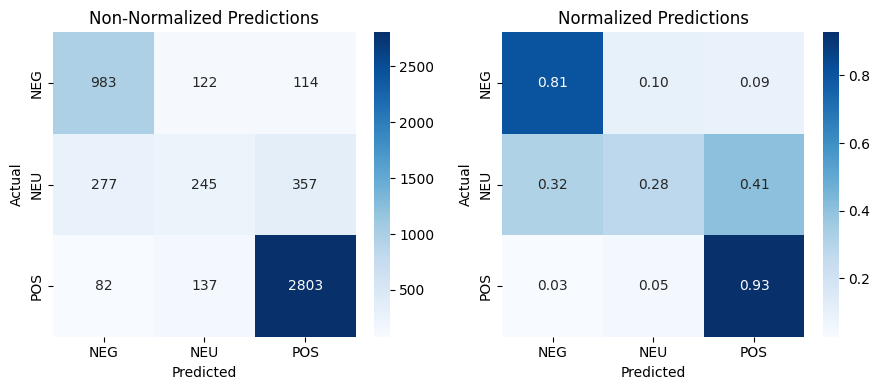

In [15]:
class_names = ['NEG', 'NEU', 'POS']

# Create a confusion matrix
cm = confusion_matrix(real_values, predicts)

# Create a non-normalized confusion matrix plot
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Non-Normalized Predictions')

# Create a normalized confusion matrix plot
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Predictions')

plt.tight_layout()
plt.show()

In [16]:
def get_index_wrong(real_values, predicts):
    index_wrong = []
    for i in range(len(real_values)):
        if real_values[i] != predicts[i]:
            index_wrong.append(i)
    return index_wrong

index_list = get_index_wrong(real_values, predicts)
for i in range(10):
    print(test_df.iloc[index_list[i]].comment)
    print(f'Predicted: ({class_names[predicts[index_list[i]]]})'
    f'--vs-- Real label: ({class_names[real_values[index_list[i]]]})')
    print('-'*50)

mẹ kiép bán hang kiêu lua đảo lút nguồn hỏng mẹ no duaday nguồn thi hok cam đk ổ nao vua thêm cái day vga cung hong đm bán hàng có tâm vl chất lượng sản phẩm tuyệt vời
Predicted: (POS)--vs-- Real label: (NEG)
--------------------------------------------------
hàng hơi khác hìn , nhưng cũng tạm đk
Predicted: (NEU)--vs-- Real label: (NEG)
--------------------------------------------------
voucher mua 95k dc 1 piza size m ma an xong thanh toan them 89k
Predicted: (POS)--vs-- Real label: (NEG)
--------------------------------------------------
vải áo đợt này mỏng hơn vải áo đợt trước do ạ
Predicted: (NEU)--vs-- Real label: (NEG)
--------------------------------------------------
đặt 3 cái
Predicted: (NEU)--vs-- Real label: (NEG)
--------------------------------------------------
mình nghĩ ảnh trải sàn mới là ảnh thật áo , vì áo trắng cúc màu đen . còn mẫu mặc cúc màu trắng là k phải
Predicted: (NEU)--vs-- Real label: (NEG)
--------------------------------------------------
lại cho mình 2 t

In [17]:
def infer(text, tokenizer, max_len=64):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')
    print('-'*50)

In [18]:
import string
import re
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    text = text.lower()
    text = re.sub(emoji_pattern, " ", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text).lower()
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    # text = re.sub(r"(\d)([^\d.])", r"\1 \2", text)
    # text = re.sub(r"([^\d.])(\d)", r"\1 \2", text)
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text)
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]
    text = re.sub(r"\s+", " ", text)
    return text

In [19]:
texts = [
    'mặt hàng này chất lượng cao',
    'nhìn áo thì tôi cũng phải chê vội',
    'áo quá đẹp, mê shop quá',
    'áo còn ngon hơn cả người yêu cũ của em',
    'trên cả tuyệt vời',
    'quá tệ, chắc phải đánh giá shop 1 sao',
    'Ngon - bổ - khá rẻ bác nhé, sẽ ủng hộ shop trong thời gian tới',
]
for text in texts:
  text = clean_text(text)
  infer(text, tokenizer)

Text: mặt hàng này chất lượng cao
Sentiment: POS
--------------------------------------------------
Text: nhìn áo thì tôi cũng phải chê vội
Sentiment: POS
--------------------------------------------------
Text: áo quá đẹp , mê shop quá
Sentiment: POS
--------------------------------------------------
Text: áo còn ngon hơn cả người yêu cũ của em
Sentiment: POS
--------------------------------------------------
Text: trên cả tuyệt vời
Sentiment: POS
--------------------------------------------------
Text: quá tệ , chắc phải đánh giá shop 1 sao
Sentiment: NEG
--------------------------------------------------
Text: ngon - bổ - khá rẻ bác nhé , sẽ ủng hộ shop trong thời gian tới
Sentiment: POS
--------------------------------------------------
